In [1]:
import helper
import network

from helper import *
from network import *

torch.manual_seed(17)
#np.random.seed(17)

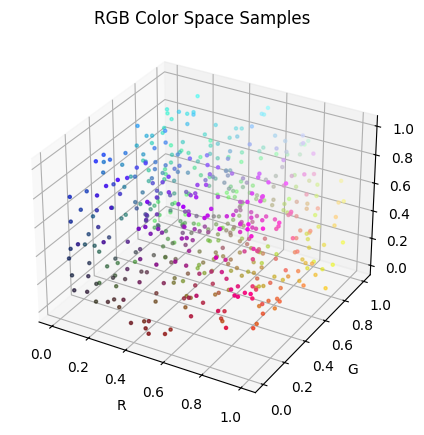

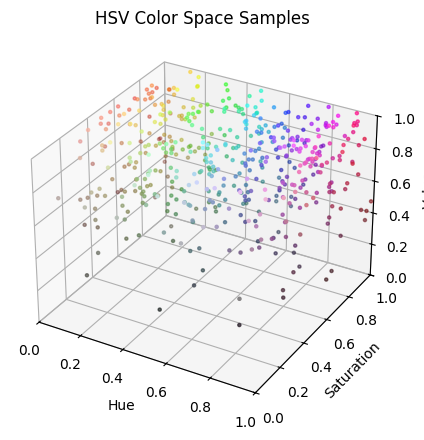

Model architecture:
RGBtoHSV(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)
Epoch [10/100], Loss: 0.0066
Epoch [20/100], Loss: 0.0046
Epoch [30/100], Loss: 0.0030
Epoch [40/100], Loss: 0.0026
Epoch [50/100], Loss: 0.0021
Epoch [60/100], Loss: 0.0015
Epoch [70/100], Loss: 0.0025
Epoch [80/100], Loss: 0.0017
Epoch [90/100], Loss: 0.0014
Epoch [100/100], Loss: 0.0013


In [128]:
# Generate and visualize data
n_samples = 500
batch_size = 64

X, y = prepare_data(n_samples)
visualize_samples(X.numpy())
visualize_hsv_samples(y.numpy())

# Create model
model = RGBtoHSV()
print("Model architecture:")
print(model)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Prepare data
rgb_data = generate_rgb_samples(n_samples)
hsv_data = rgb_to_hsv_batch(rgb_data)

# Create dataset and dataloader
dataset = RGBHSVDataset(rgb_data, hsv_data)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create and train model
model = RGBtoHSV()
train_model(model, train_loader, num_epochs=100)

In [129]:
visualize_model_structure(model)


Neural Network Structure
#   Layer Type           Input Shape     Output Shape    Parameters   Activation
-------------------------------------------------------------------------------------
0   Input                (-, 3)          (-, 3)          0            None      
1   Linear               (-, 3)          (-, 128)        512          None      
2   ReLU                 (-, 128)        (-, 128)        0            ReLU      
3   Linear               (-, 128)        (-, 128)        16512        None      
4   ReLU                 (-, 128)        (-, 128)        0            ReLU      
5   Linear               (-, 128)        (-, 64)         8256         None      
6   ReLU                 (-, 64)         (-, 64)         0            ReLU      
7   Linear               (-, 64)         (-, 3)          195          None      
Total trainable parameters: 25,475
Final output shape: (batch_size, 3) [HSV values]


In [130]:
inputs, activations, outputs = collect_activations(model, train_loader)
print("Input shape:", inputs.shape)
print("Activation shape:", activations.shape)
print("Output shape:", outputs.shape)

Input shape: (500, 3)
Activation shape: (500, 640)
Output shape: (500, 3)


Input RGB: [[0.46861503 0.18678172 0.22810845]]
Activation shape: (500, 640)
Output HSV: [[0.89718175 0.5484075  0.48412508]]


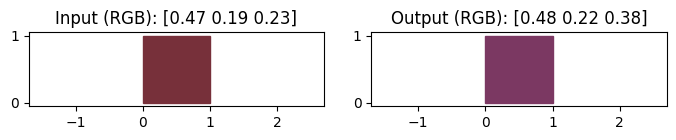

In [133]:
rgb_color = np.random.uniform(0, 1, 3) 
new_input, new_activations, new_output = collect_single_color_activations(model, rgb_color)
print("Input RGB:", new_input)
print("Activation shape:", activations.shape)
print("Output HSV:", new_output)

compare_values_side_by_side(new_input[0], hsv_to_rgb(new_output[0][0],new_output[0][1],new_output[0][2]), 
                          titles=('Input', 'Output'),
                          color_space='rgb',
                          decimals=2)

In [134]:
def plot_pca_cumulative_variance(activations, max_components=None, title="PCA Cumulative Explained Variance"):
    """
    Create PCA cumulative variance plot for activation data
    
    Args:
        activations: Activation values from neural network (n_samples x n_features)
        max_components: Maximum number of components to evaluate (default=None, uses all)
        title: Plot title (default="PCA Cumulative Explained Variance")
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    # Handle max_components
    n_features = activations.shape[1]
    if max_components is None:
        max_components = n_features
    else:
        max_components = min(max_components, n_features)
    
    # Standardize the features
    scaler = StandardScaler()
    activations_scaled = scaler.fit_transform(activations)
    
    # Apply PCA
    pca = PCA(n_components=max_components)
    pca.fit(activations_scaled)
    
    # Calculate cumulative variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
             cumulative_variance_ratio, 
             'b-', 
             linewidth=2)
    
    # Add reference lines for different variance levels
    variance_levels = [0.8, 0.9, 0.95, 0.99]
    for level in variance_levels:
        n_components = np.argmax(cumulative_variance_ratio >= level) + 1
        if n_components <= max_components:  # Only show if within range
            plt.axhline(y=level, color='r', linestyle='--', alpha=0.3)
            plt.axvline(x=n_components, color='r', linestyle='--', alpha=0.3)
            plt.text(min(n_components + 5, max_components - 5), level, 
                    f'{level*100:.0f}% ({n_components} components)', 
                    verticalalignment='bottom')
    
    plt.grid(True, alpha=0.3)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nComponents needed for variance explained:")
    for level in variance_levels:
        n_components = np.argmax(cumulative_variance_ratio >= level) + 1
        if n_components <= max_components:
            print(f"{level*100:.0f}% variance: {n_components} components")

In [ ]:
def fit_pca_transform(train_activations, test_activations, n_components):
    """
    Fit PCA on training data and transform both training and test data
    
    Args:
        train_activations: Training set activations to fit PCA
        test_activations: Test/new activations to transform
        n_components: Number of PCA components to keep
        
    Returns:
        tuple: (reduced_train, reduced_test, pca_model, scaler)
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    # Ensure input is 2D array
    if test_activations.ndim == 1:
        test_activations = test_activations.reshape(1, -1)
    
    # Standardize the features
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_activations)
    test_scaled = scaler.transform(test_activations)
    
    # Fit PCA on training data
    pca = PCA(n_components=n_components)
    reduced_train = pca.fit_transform(train_scaled)
    
    # Transform test data using fitted PCA
    reduced_test = pca.transform(test_scaled)
    
    # Print variance explained
    total_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Total variance explained by {n_components} components: {total_variance:.4f}")
    print(f"Training data shape: {reduced_train.shape}")
    print(f"Test data shape: {reduced_test.shape}")
    
    return reduced_train, reduced_test, pca, scaler

def get_top_activated_neurons(activations, n_neurons=5):
    """
    Find the top n most activated neurons based on mean activation across all samples
    and return masked activations containing only those neurons
    
    Args:
        activations: Activation values from neural network (n_samples x n_features)
        n_neurons: Number of top neurons to select (default=5)
        
    Returns:
        tuple: (masked_activations, neuron_indices, mean_activations)
            - masked_activations: Original activations filtered to only top n neurons
            - neuron_indices: Indices of the top n neurons
            - mean_activations: Mean activation values for the top n neurons
    """
    # Calculate mean activation across all samples
    mean_activations = np.mean(activations, axis=0)  # Shape: (640,)
    
    # Get indices of top n activated neurons
    top_neuron_indices = np.argsort(mean_activations)[-n_neurons:]
    
    # Create masked activations using these indices
    masked_activations = activations[:, top_neuron_indices]
    
    # Get the mean activation values for these neurons
    top_mean_activations = mean_activations[top_neuron_indices]
    
    print(f"Shape of masked activations: {masked_activations.shape}")
    print("\nTop {n_neurons} neurons (index: mean activation):")
    for idx, mean_act in zip(top_neuron_indices, top_mean_activations):
        print(f"Neuron {idx}: {mean_act:.4f}")
    
    return masked_activations, top_neuron_indices, top_mean_activations

Input RGB: [[0.64922243 0.87877333 0.20984644]]
Activation shape: (500, 640)
Output HSV: [[0.18349563 0.76723135 0.8928624 ]]


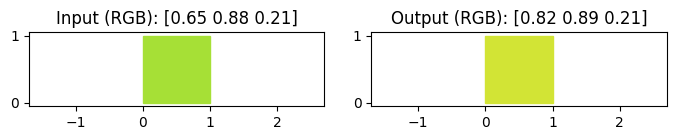

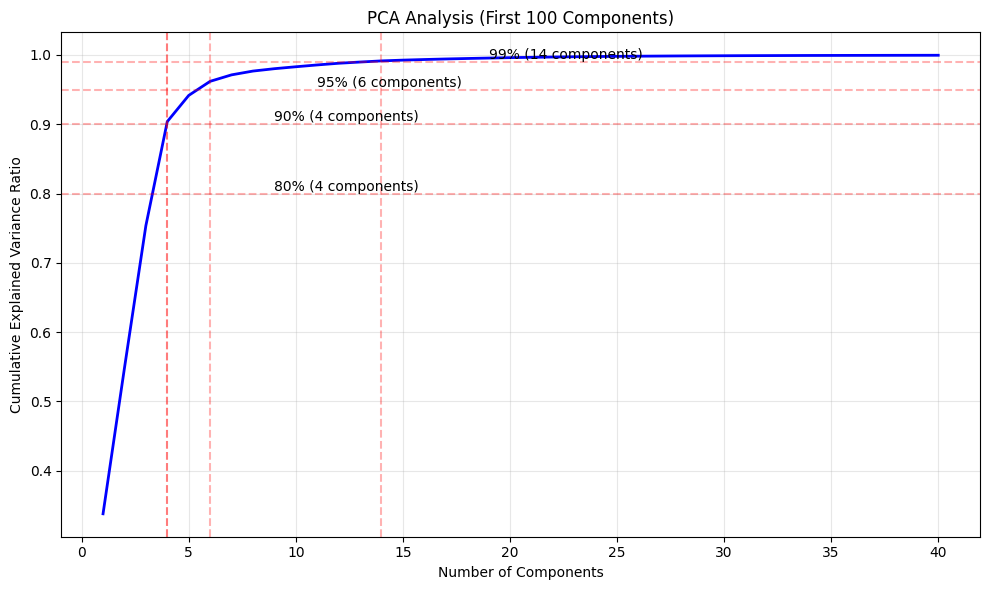


Components needed for variance explained:
80% variance: 4 components
90% variance: 4 components
95% variance: 6 components
99% variance: 14 components
Total variance explained by 28 components: 0.9985
Training data shape: (500, 28)
Test data shape: (1, 28)
Shape of masked activations: (500, 3)

Top {n_neurons} neurons (index: mean activation):
Neuron 554: 1.1317
Neuron 520: 1.1601
Neuron 584: 1.1601

Whole 640 Neurons:

Found 10 nearest neighbors:
Input space - Distance range: 0.0992 to 0.1548
Activation space - Distance range: 0.8768 to 1.9512
Output space - Distance range: 0.0544 to 0.1056

First 128 Neurons:

Found 10 nearest neighbors:
Input space - Distance range: 0.0992 to 0.1548
Activation space - Distance range: 0.3979 to 0.6878
Output space - Distance range: 0.0544 to 0.1056

PCA reduced:

Found 10 nearest neighbors:
Input space - Distance range: 0.0992 to 0.1548
Activation space - Distance range: 3.9143 to 8.0797
Output space - Distance range: 0.0544 to 0.1056

Highest Neuro

In [145]:
rgb_color = np.random.uniform(0, 1, 3) 
new_input, new_activations, new_output = collect_single_color_activations(model, rgb_color)
print("Input RGB:", new_input)
print("Activation shape:", activations.shape)
print("Output HSV:", new_output)

compare_values_side_by_side(new_input[0], hsv_to_rgb(new_output[0][0],new_output[0][1],new_output[0][2]), 
                          titles=('Input', 'Output'),
                          color_space='rgb',
                          decimals=2)

plot_pca_cumulative_variance(activations, max_components=40, 
                           title="PCA Analysis (First 100 Components)")

# Reduce Activations using PCA
reduced_acts, new_reduced_acts, pca_model, scaler = fit_pca_transform(
    activations,           # Full dataset
    new_activations,    # Single sample
    n_components=28
)

# Reduce Activastions using highest neuron activations
masked_acts, top_indices, means = get_top_activated_neurons(activations[:,0:640], n_neurons=3)

# Use the same neurons for a new sample
new_masked_acts = new_activations[:, top_indices]

print("\nWhole 640 Neurons:")
knn_results = find_k_nearest_neighbors(
    inputs, activations, outputs,
    new_input, new_activations, new_output,
    k=10
)

print("\nFirst 128 Neurons:")
knn_results = find_k_nearest_neighbors(
    inputs, activations[:,0:128], outputs,
    new_input, new_activations[:,0:128], new_output,
    k=10
)

print("\nPCA reduced:")
knn_results = find_k_nearest_neighbors(
    inputs, reduced_acts, outputs,
    new_input, new_reduced_acts, new_output,
    k=10
)

print("\nHighest Neuron Reduced:")
knn_results = find_k_nearest_neighbors(
    inputs, masked_acts, outputs,
    new_input, new_masked_acts, new_output,
    k=10
)

In [9]:
def visualize_top_neuron_activations(masked_activations, input_colors, top_indices, 
                                   title="Top 3 Neuron Activations", flip_view=False):
    """
    Visualize the activation patterns of top 3 neurons in 3D space, colored by their original RGB values
    
    Args:
        masked_activations: Activation values for top 3 neurons (n_samples x 3)
        input_colors: Original RGB colors of the samples (n_samples x 3)
        top_indices: Indices of the selected neurons
        title: Plot title
        flip_view: If True, rotates view 180 degrees (default=False)
    """
    if masked_activations.shape[1] != 3:
        raise ValueError("This visualization requires exactly 3 neurons (got {})".format(
            masked_activations.shape[1]))
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create scatter plot with original RGB colors
    scatter = ax.scatter(
        masked_activations[:, 0],  # First neuron
        masked_activations[:, 1],  # Second neuron
        masked_activations[:, 2],  # Third neuron
        c=input_colors,            # Use original RGB colors
        alpha=0.6
    )
    
    # Set labels
    ax.set_xlabel(f'Neuron {top_indices[0]}')
    ax.set_ylabel(f'Neuron {top_indices[1]}')
    ax.set_zlabel(f'Neuron {top_indices[2]}')
    
    # Set title
    plt.title(title)
    
    # Adjust view angle
    if flip_view:
        ax.view_init(elev=20, azim=225)  # Rotated 180 degrees
    else:
        ax.view_init(elev=20, azim=45)   # Original view
    
    plt.tight_layout()
    plt.show()

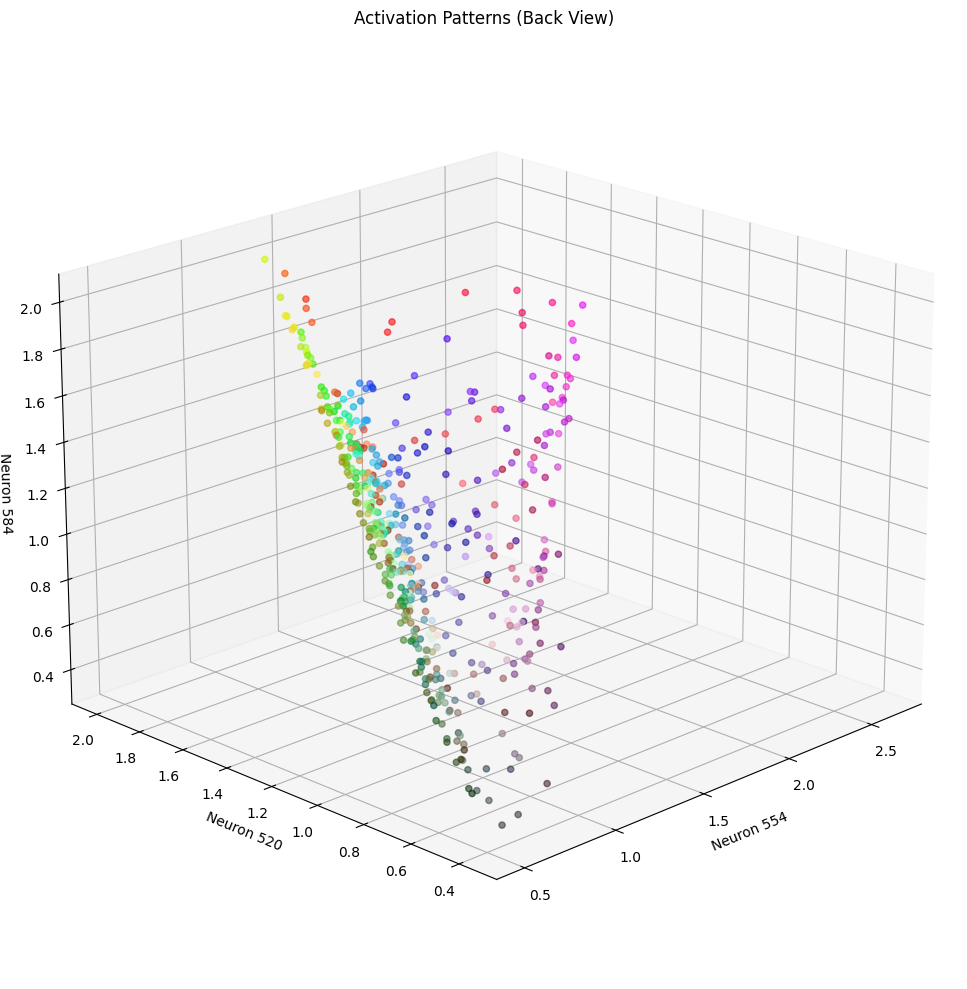

In [146]:
# Visualize with original RGB colors
visualize_top_neuron_activations(
    masked_acts,
    inputs,
    top_indices,
    title="Activation Patterns (Back View)",
    flip_view=True
)

In [147]:
def plot_activation_values(activations, title="Neuron Activation Values", figsize=(15, 5)):
    """
    Plot activation values of all neurons
    
    Args:
        activations: Activation values (n_features,) or (1, n_features)
        title: Plot title (default="Neuron Activation Values")
        figsize: Figure size (width, height) (default=(15, 5))
    """
    # Ensure activations is 1D
    if activations.ndim > 1:
        activations = activations.flatten()
    
    plt.figure(figsize=figsize)
    plt.plot(range(len(activations)), activations, 'b-', linewidth=1)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Neuron Index')
    plt.ylabel('Activation Value')
    plt.title(title)
    
    # Add some statistics
    plt.axhline(y=np.mean(activations), color='r', linestyle='--', alpha=0.5, 
                label=f'Mean: {np.mean(activations):.4f}')
    plt.axhline(y=np.median(activations), color='g', linestyle='--', alpha=0.5,
                label=f'Median: {np.median(activations):.4f}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

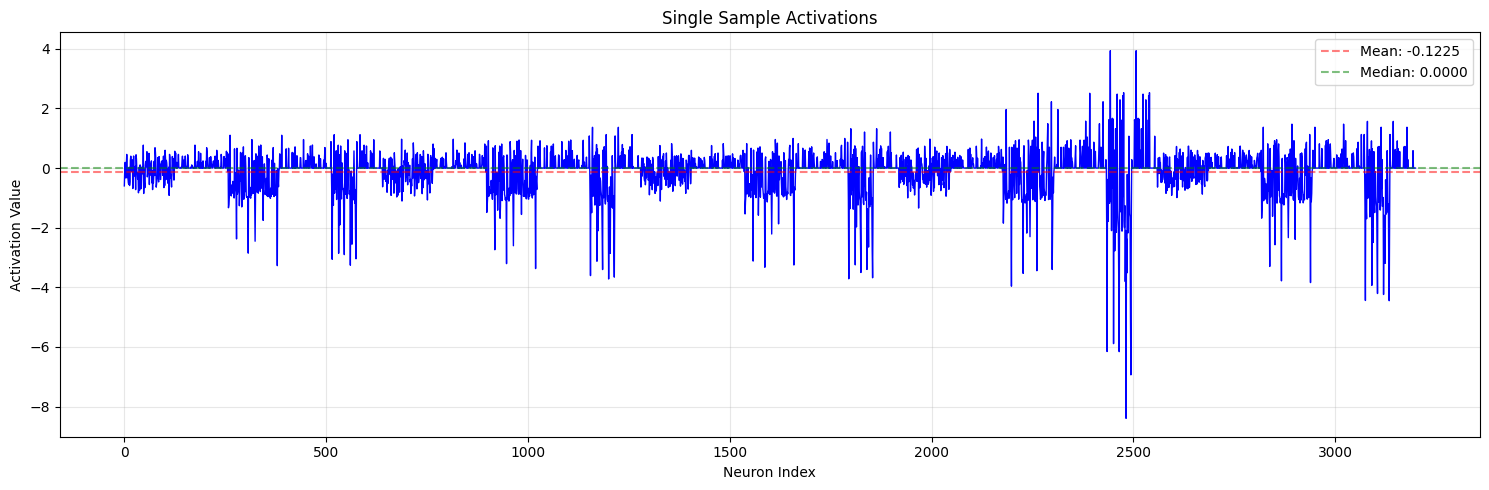

In [148]:
# For a single sample:
plot_activation_values(activations[0:5], title="Single Sample Activations")

# For mean activations across all samples:
# mean_acts = np.mean(activations, axis=0)
# plot_activation_values(mean_acts, title="Mean Activation Values Across Samples")


In [149]:
def plot_multiple_activation_patterns(activations, input_colors=None, n_samples=5, 
                                    title="Multiple Activation Patterns", figsize=(25, 10)):
    """
    Plot activation values for multiple random samples with their RGB colors
    
    Args:
        activations: Activation values from neural network (n_samples x n_features)
        input_colors: Original RGB colors of the samples (n_samples x 3)
        n_samples: Number of random samples to plot (default=5)
        title: Plot title
        figsize: Figure size (width, height)
    """
    # Get random sample indices
    random_indices = np.random.choice(activations.shape[0], size=n_samples, replace=False)
    
    plt.figure(figsize=figsize)
    
    # Plot each sample with its RGB color or random if colors not provided
    for i, idx in enumerate(random_indices):
        if input_colors is not None:
            color = input_colors[idx]
            label = f'Sample {idx} (RGB: {color[0]:.2f}, {color[1]:.2f}, {color[2]:.2f})'
        else:
            color = None  # matplotlib will choose random color
            label = f'Sample {idx}'
            
        plt.plot(range(activations.shape[1]), 
                activations[idx], 
                color=color,
                alpha=0.25, 
                label=label)
    
    plt.grid(True, alpha=0.3)
    plt.xlabel('Neuron Index')
    plt.ylabel('Activation Value')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



C:\Users\lukas\AppData\Local\Temp\ipykernel_2624\177150051.py:38: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



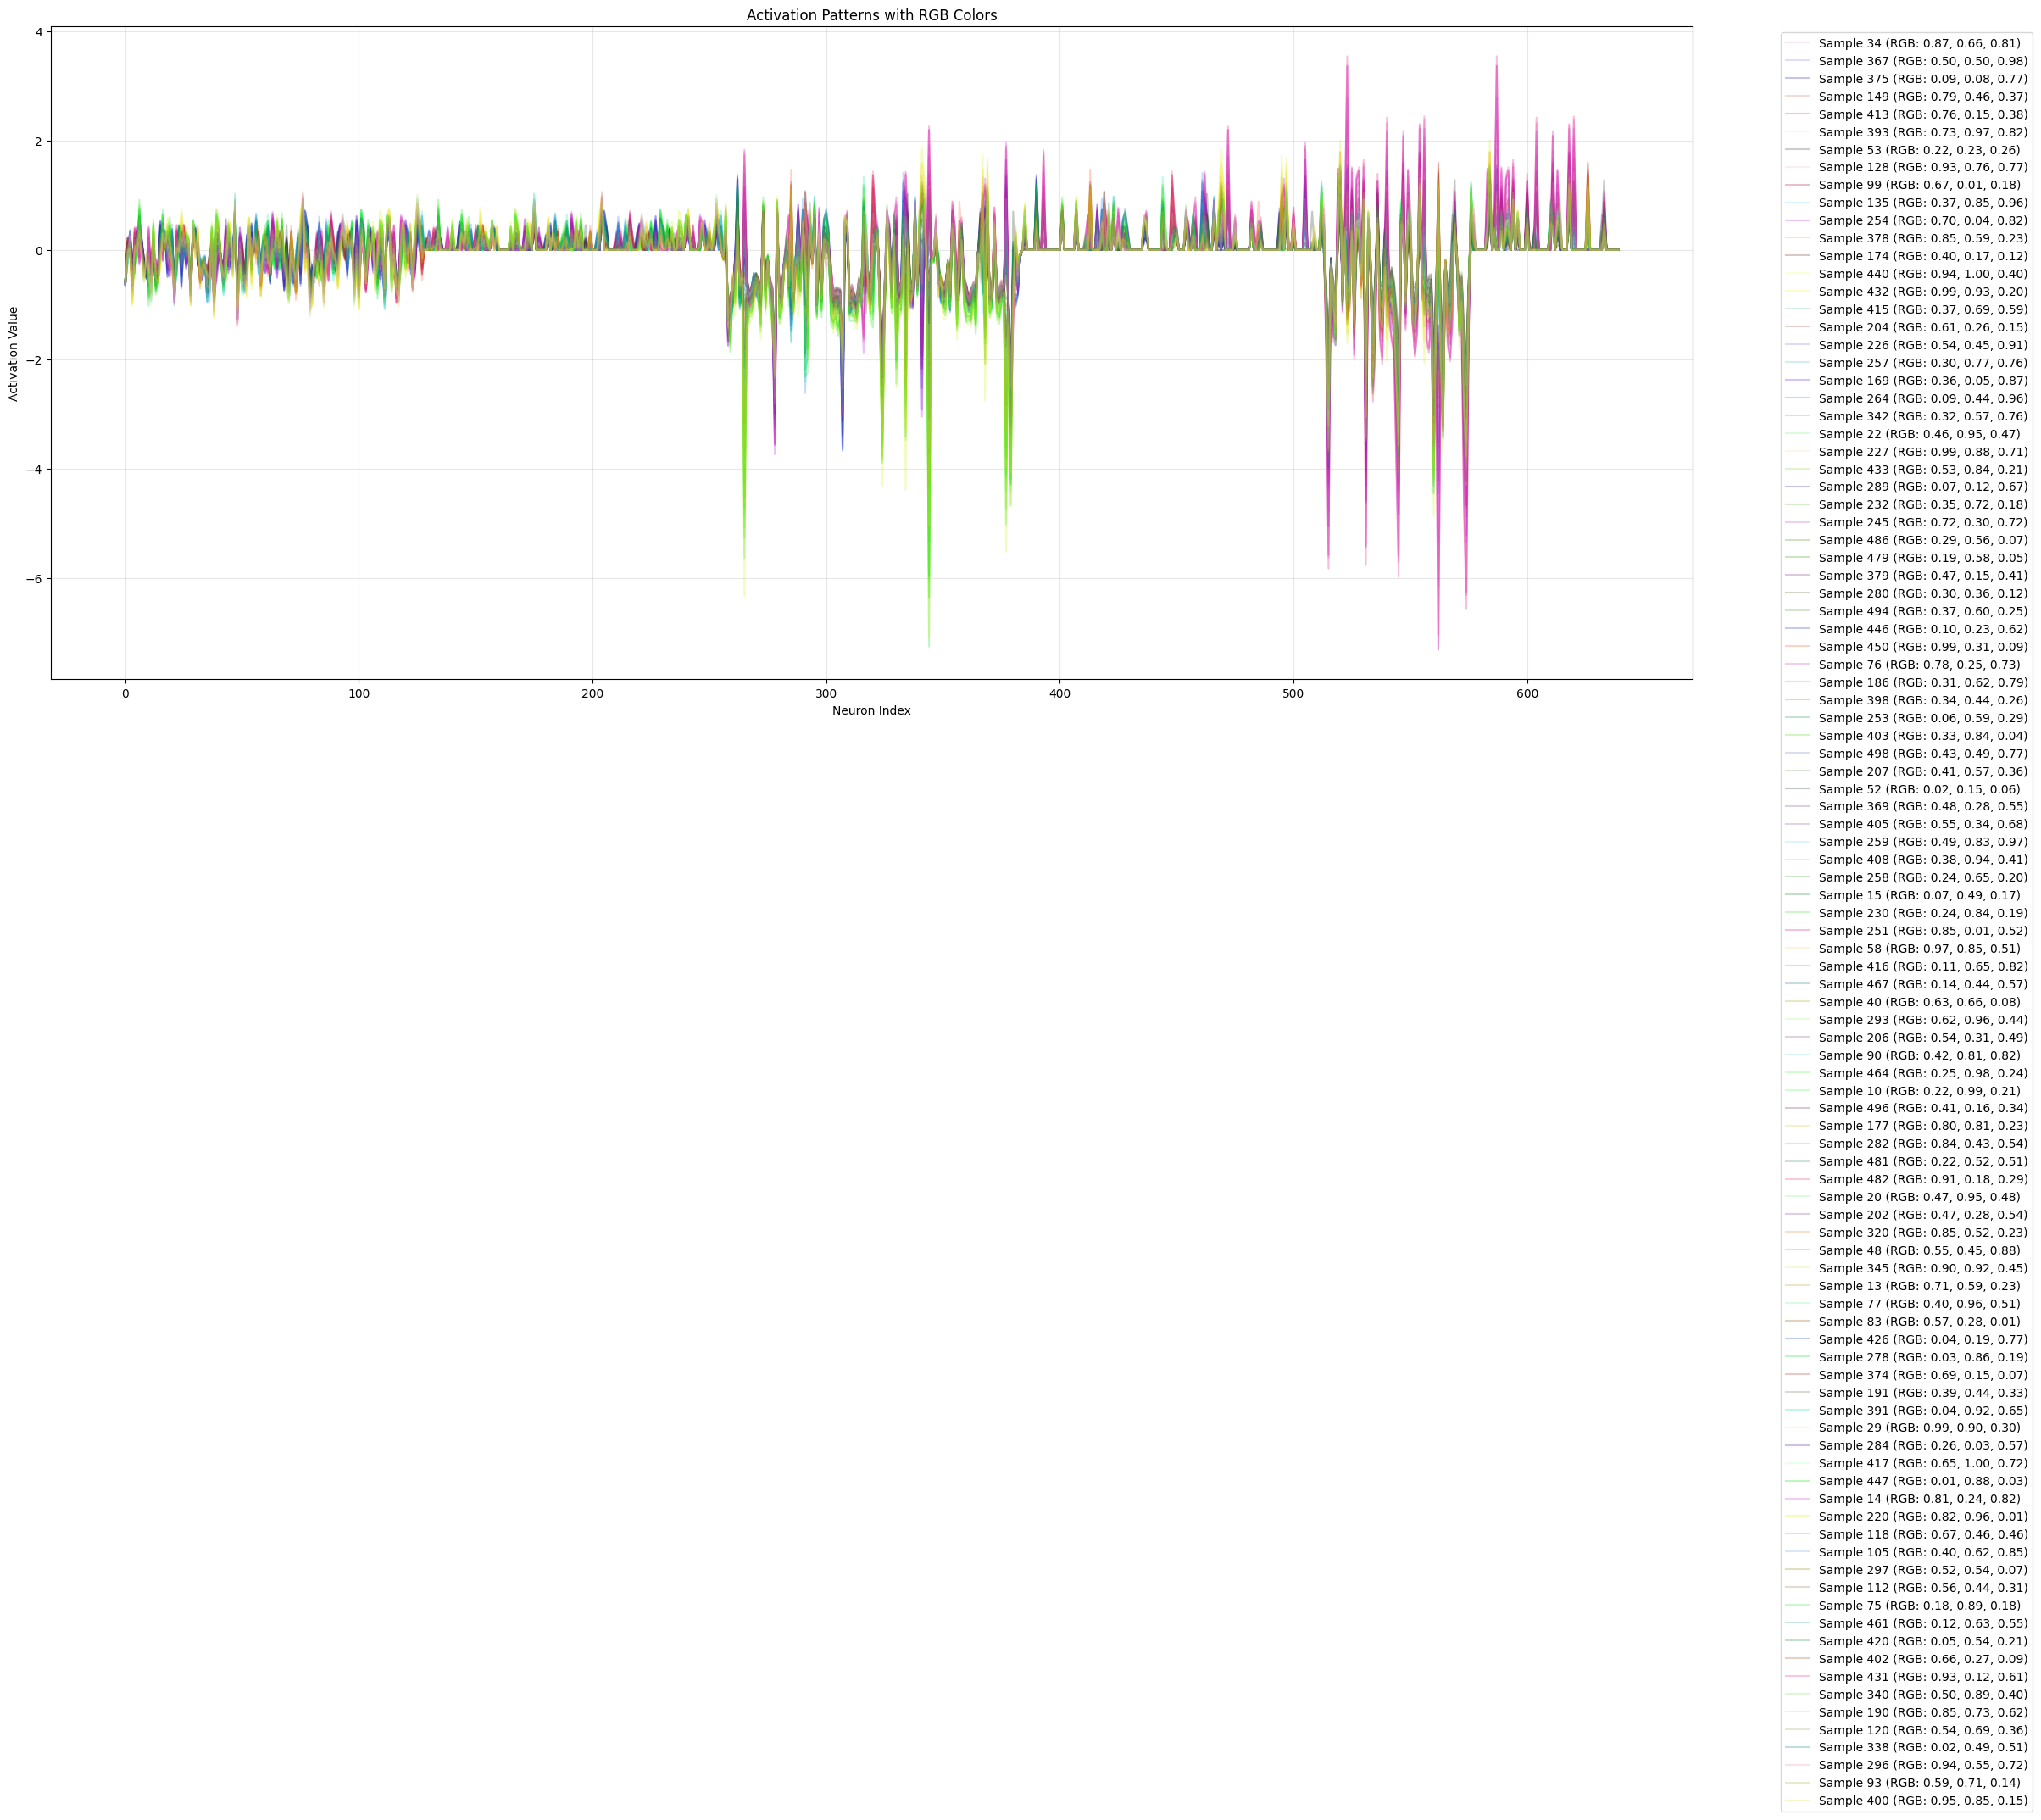

In [150]:
plot_multiple_activation_patterns(activations, 
                                input_colors=inputs,  # Pass RGB colors
                                n_samples=100, 
                                title="Activation Patterns with RGB Colors")

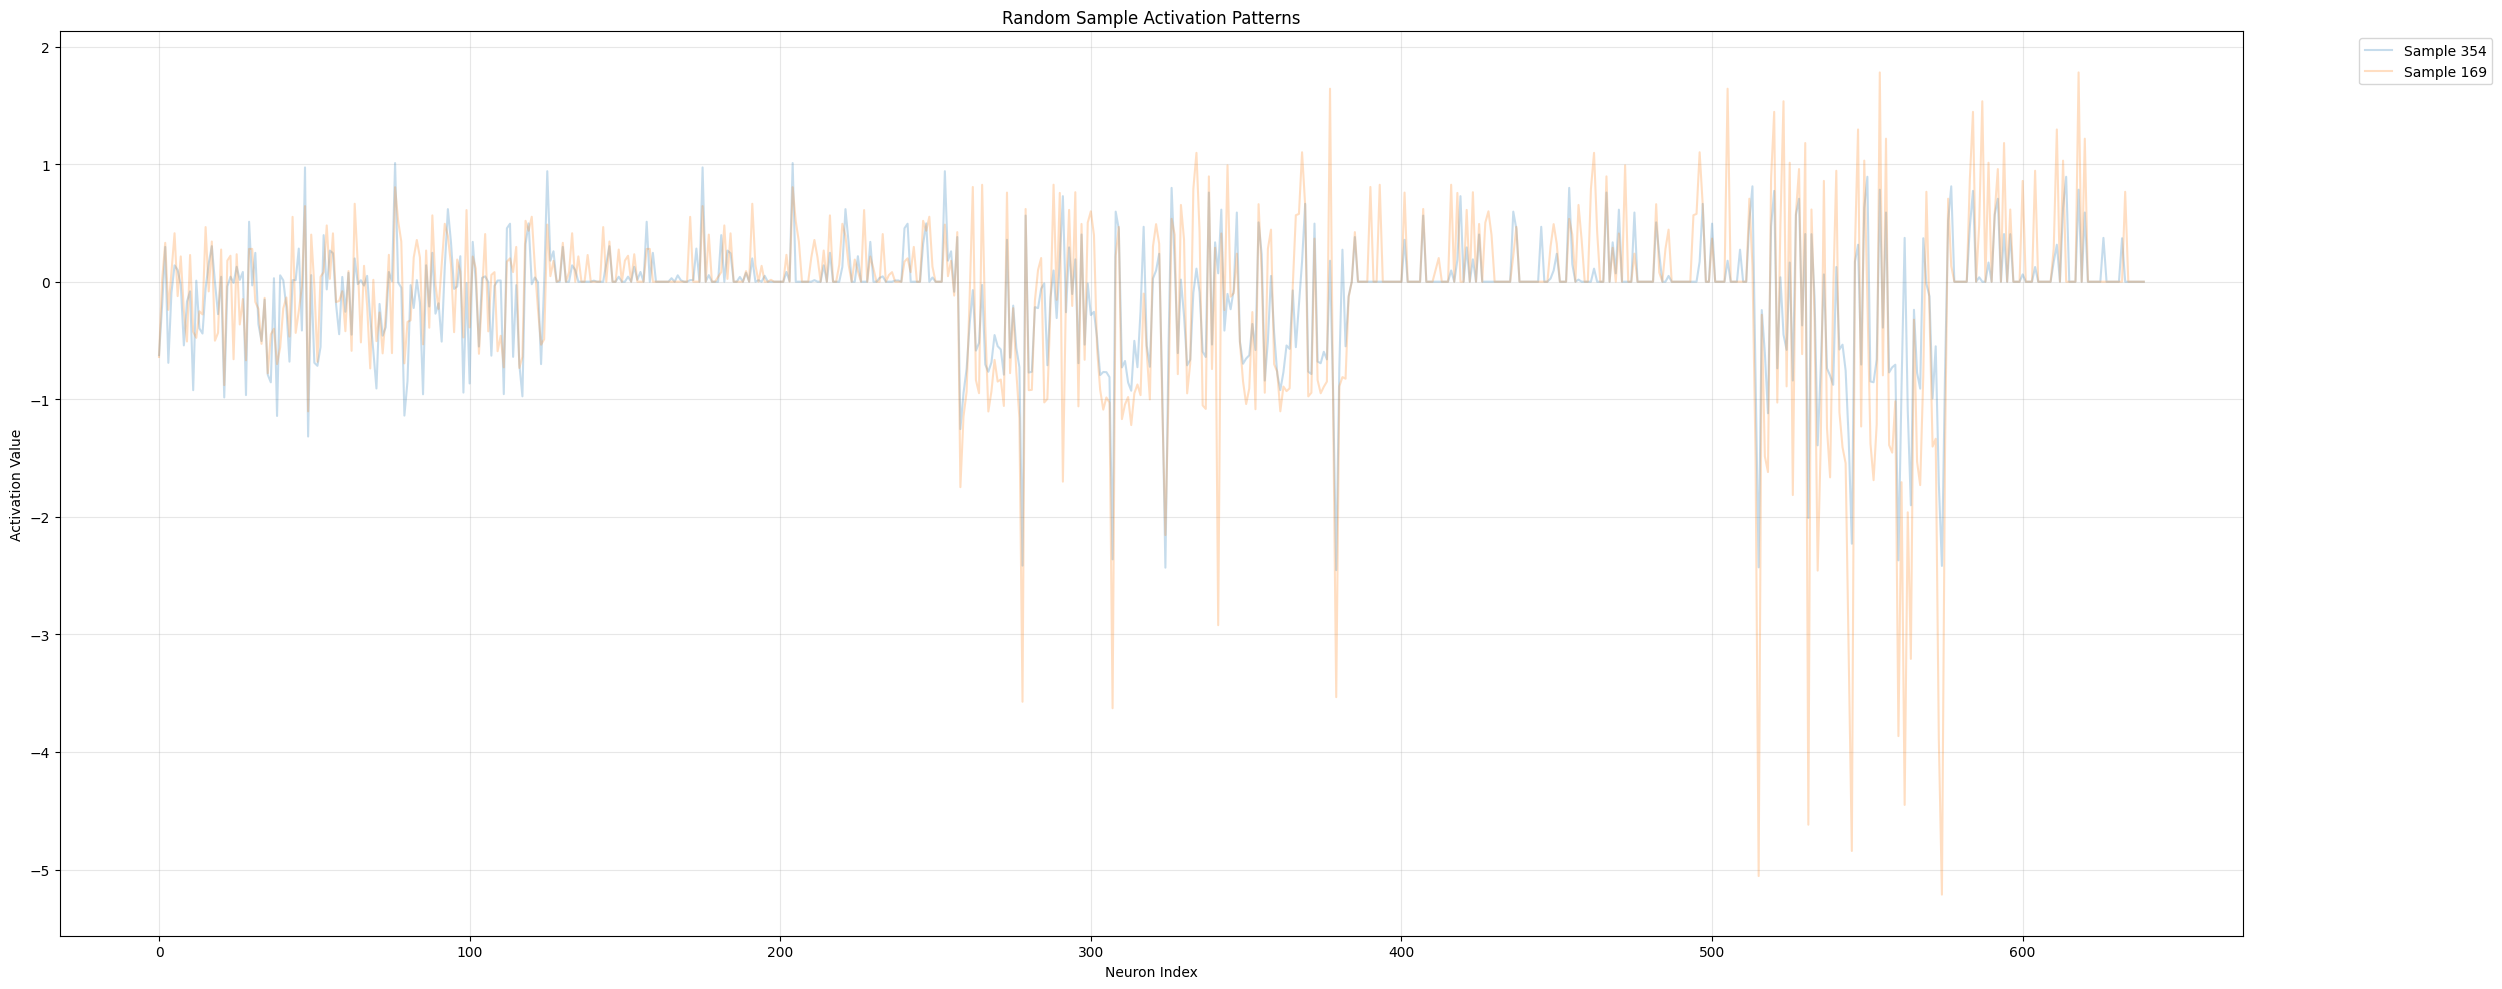

In [151]:
# Plot 5 random activation patterns
plot_multiple_activation_patterns(activations, n_samples=2, 
                                title="Random Sample Activation Patterns")

In [152]:
def split_activations_by_layer(activations, layer_sizes=[128, 128, 64]):
    """
    Split activations into arrays by layer (Linear + ReLU pairs)
    
    Args:
        activations: Full activation values (n_samples x n_features)
        layer_sizes: List of layer sizes in order [128, 128, 128, 128, 128]
        
    Returns:
        dict: Dictionary containing activation arrays for each layer
            - 'linear1': First linear layer
            - 'relu1': First ReLU layer
            - 'linear2': Second linear layer
            - etc.
    """
    layers = {}
    start_idx = 0
    
    # Split activations by layer
    for i, size in enumerate(layer_sizes, 1):
        # Linear layer
        end_idx = start_idx + size
        layers[f'linear{i}'] = activations[:, start_idx:end_idx]
        start_idx = end_idx
        
        # ReLU layer (same size as linear)
        end_idx = start_idx + size
        layers[f'relu{i}'] = activations[:, start_idx:end_idx]
        start_idx = end_idx
    
    # Print layer shapes
    print("Activation shapes by layer:")
    for name, layer in layers.items():
        print(f"{name}: {layer.shape}")
        
    return layers


Activation shapes by layer:
linear1: (500, 128)
relu1: (500, 128)
linear2: (500, 128)
relu2: (500, 128)
linear3: (500, 64)
relu3: (500, 64)


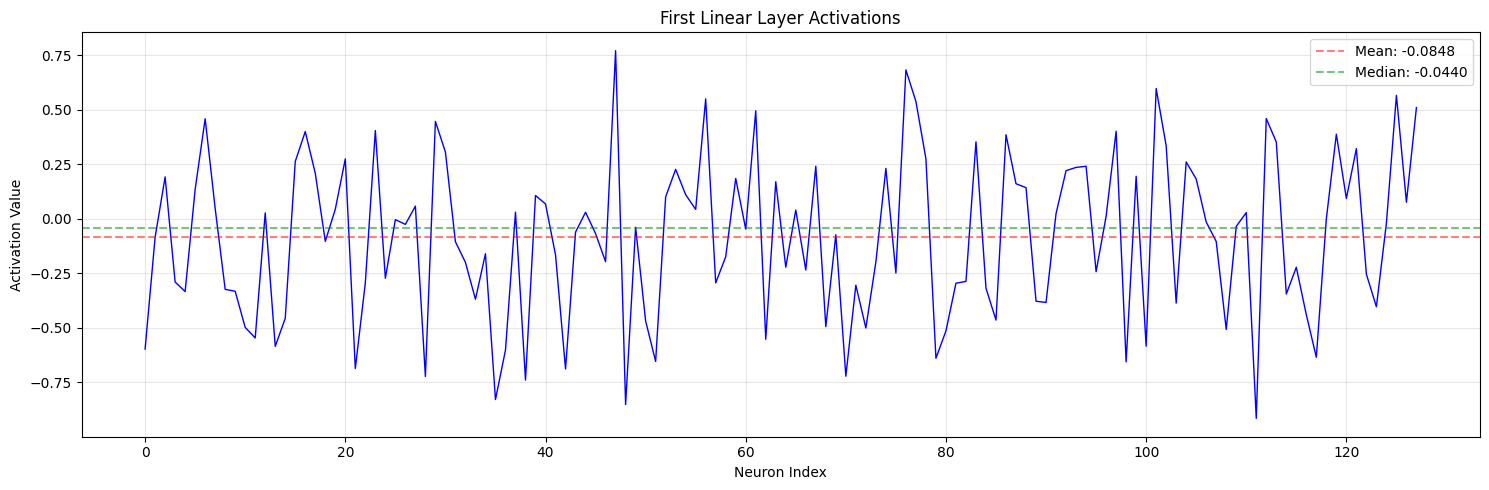

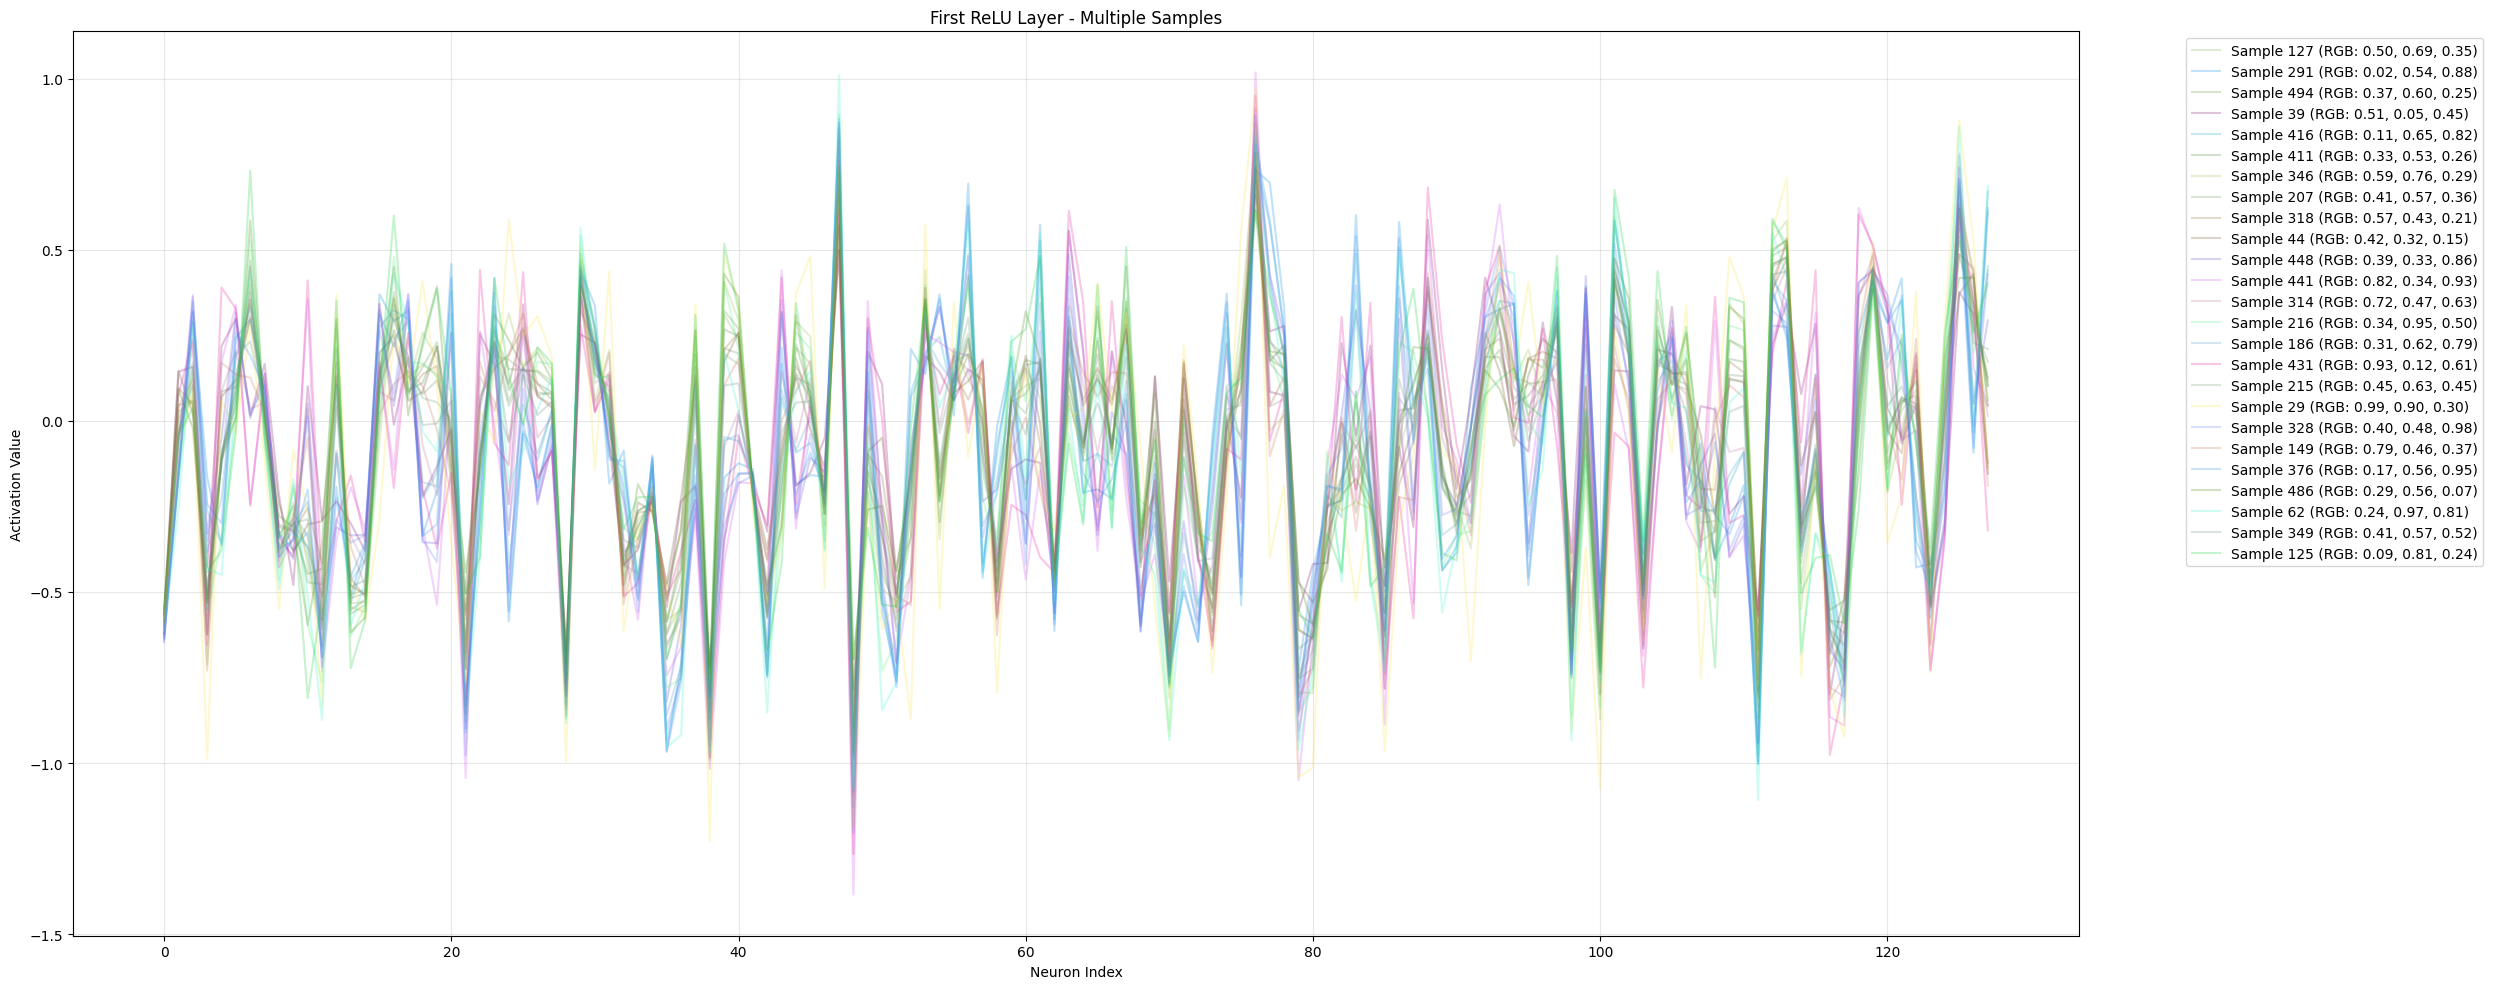

In [153]:
layer_activations = split_activations_by_layer(activations)

# Access specific layers
linear1_acts = layer_activations['linear1']
relu1_acts = layer_activations['relu1']
linear2_acts = layer_activations['linear2']
relu2_acts = layer_activations['relu2']
linear3_acts = layer_activations['linear3']
relu3_acts = layer_activations['relu3']


# Visualize activations for a specific layer
plot_activation_values(linear1_acts[0], title="First Linear Layer Activations")
plot_multiple_activation_patterns(linear1_acts, input_colors=inputs, n_samples=25, 
                                title="First ReLU Layer - Multiple Samples")

In [154]:
def reduce_layer_dimensions(layer_activations, n_components=3):
    """
    Reduce dimensionality of each layer's activations to specified number of components
    
    Args:
        layer_activations: Dictionary containing layer activations from split_activations_by_layer
        n_components: Number of components to reduce to (default=3)
        
    Returns:
        dict: Dictionary containing reduced activations for each layer
            - 'linear1_reduced': First linear layer reduced
            - 'relu1_reduced': First ReLU layer reduced
            etc.
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    reduced_layers = {}
    
    # Process each layer
    for layer_name, layer_data in layer_activations.items():
        # Standardize the features
        scaler = StandardScaler()
        layer_scaled = scaler.fit_transform(layer_data)
        
        # Apply PCA
        n_comp = min(n_components, layer_data.shape[1])  # Cannot exceed feature count
        pca = PCA(n_components=n_comp)
        reduced_data = pca.fit_transform(layer_scaled)
        
        # Store reduced data
        reduced_layers[f"{layer_name}_reduced"] = reduced_data
        
        # Print variance explained for this layer
        var_explained = np.sum(pca.explained_variance_ratio_)
        print(f"{layer_name}: {layer_data.shape} -> {reduced_data.shape} "
              f"(Variance explained: {var_explained:.3f})")
    
    return reduced_layers

In [195]:
# Reduce all layers to 3 dimensions
reduced_activations = reduce_layer_dimensions(layer_activations, n_components=10)

# Access reduced layers
linear1_reduced = reduced_activations['linear1_reduced']
relu1_reduced = reduced_activations['relu1_reduced']
linear2_reduced = reduced_activations['linear2_reduced']
relu2_reduced = reduced_activations['relu2_reduced']
linear3_reduced = reduced_activations['linear3_reduced']
relu3_reduced = reduced_activations['relu3_reduced']




linear1: (500, 128) -> (500, 10) (Variance explained: 1.000)
relu1: (500, 128) -> (500, 10) (Variance explained: 0.980)
linear2: (500, 128) -> (500, 10) (Variance explained: 0.996)
relu2: (500, 128) -> (500, 10) (Variance explained: 0.977)
linear3: (500, 64) -> (500, 10) (Variance explained: 0.997)
relu3: (500, 64) -> (500, 10) (Variance explained: 0.997)


In [156]:
def flatten_layer_activations(reduced_activations, layer_order=None):
    """
    Flatten reduced activations from all layers into a single numpy array
    
    Args:
        reduced_activations: Dictionary of reduced layer activations
        layer_order: Optional list to specify layer order (default=None, uses standard order)
        
    Returns:
        numpy.ndarray: Array of shape (n_samples, n_components * n_layers)
        list: Names of layers in order they were flattened
    """
    # If no layer order specified, create standard order
    if layer_order is None:
        layer_order = []
        for i in range(1, 4):  # For 3 layer pairs
            layer_order.extend([f'linear{i}_reduced', f'relu{i}_reduced'])
    
    # Get dimensions
    n_samples = reduced_activations[layer_order[0]].shape[0]
    n_components = reduced_activations[layer_order[0]].shape[1]
    n_layers = len(layer_order)
    
    # Create output array
    flattened = np.zeros((n_samples, n_components * n_layers))
    
    # Fill array with activations from each layer
    for i, layer_name in enumerate(layer_order):
        start_idx = i * n_components
        end_idx = (i + 1) * n_components
        flattened[:, start_idx:end_idx] = reduced_activations[layer_name]
    
    print(f"Input shape per layer: {reduced_activations[layer_order[0]].shape}")
    print(f"Number of layers: {n_layers}")
    print(f"Output shape: {flattened.shape}")
    
    return flattened, layer_order

In [196]:
flattened_activations, layer_names = flatten_layer_activations(reduced_activations)

# Now flattened_activations contains all components from all layers
# Shape will be (n_samples, n_components * n_layers)
# For 2000 samples, 10 components, 6 layers: (2000, 60)

Input shape per layer: (500, 10)
Number of layers: 6
Output shape: (500, 60)


In [197]:
flattened_activations[0]

array([ 1.34037375e+00,  9.22534275e+00,  2.87989759e+00,  3.77620540e-06,
       -9.07159938e-06,  1.30868239e-06, -2.49129897e-07, -4.18921786e-07,
        2.43287758e-07, -1.65962291e-07,  5.25495410e-01,  7.63577318e+00,
       -4.59569514e-01, -1.15653157e+00, -1.91766524e+00,  1.41943884e+00,
       -3.22825044e-01, -3.29780430e-01, -1.02758431e+00,  3.84483784e-01,
       -9.99805570e-01, -1.49554789e+00, -6.82188368e+00,  1.31457257e+00,
       -7.28717804e-01, -2.14863586e+00,  3.15710716e-02,  9.75173593e-01,
       -4.70599800e-01, -8.64730656e-01, -1.13346398e+00,  2.78107953e+00,
       -2.98937201e+00, -1.35401106e+00,  2.11271450e-01, -8.77620935e-01,
       -1.27772593e+00,  7.92222857e-01,  5.75469136e-01,  2.31673755e-03,
        1.89440930e+00,  1.45995390e+00,  3.23453903e+00, -1.92371690e+00,
       -8.38902950e-01,  3.20715755e-02,  7.88331568e-01,  5.35145640e-01,
       -9.99767035e-02,  3.73970978e-02, -1.38426876e+00,  1.99802828e+00,
        2.13453889e+00, -

In [193]:
def plot_single_component_across_layers(reduced_activations, input_colors, n_samples=100, 
                                      component_idx=0, figsize=(12, 6)):
    """
    Plot a single component's value across layers while preserving layer order
    
    Args:
        reduced_activations: Dictionary of reduced layer activations
        input_colors: Original RGB colors for samples
        n_samples: Number of random samples to plot (default=100)
        component_idx: Index of the component to plot (default=0)
        figsize: Figure size (width, height)
    """
    plt.figure(figsize=figsize)
    
    # Get layer names in order they were processed (linear1, relu1, linear2, relu2, etc.)
    layer_names = []
    for i in range(1, 4):  # For 3 layer pairs
        layer_names.extend([f'linear{i}_reduced', f'relu{i}_reduced'])
    
    n_layers = len(layer_names)
    total_samples = reduced_activations[layer_names[0]].shape[0]
    
    # Select random samples
    sample_indices = np.random.choice(total_samples, size=min(n_samples, total_samples), replace=False)
    
    # Plot selected samples
    for idx in sample_indices:
        values = [reduced_activations[layer][idx, component_idx] for layer in layer_names]
        plt.plot(range(n_layers), values, '-', color=input_colors[idx], alpha=0.5)
    
    # Show layer names without '_reduced' suffix
    plt.xticks(range(n_layers), [name.replace('_reduced', '') for name in layer_names], rotation=45)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Layer')
    plt.ylabel(f'Component {component_idx} Value')
    plt.title(f'Component {component_idx} Values Across Layers (n={n_samples} samples)')
    plt.tight_layout()
    plt.show()

def plot_2d_layer_trajectories(reduced_activations, input_colors, n_samples=100,
                             x_comp=0, y_comp=1, figsize=(15, 15)):
    """
    Plot 2D trajectories for n random samples through layers
    
    Args:
        reduced_activations: Dictionary of reduced layer activations
        input_colors: Original RGB colors for samples
        n_samples: Number of random samples to plot (default=100)
        x_comp, y_comp: Component indices for axes
        figsize: Figure size (width, height)
    """
    plt.figure(figsize=figsize)
    layer_names = sorted(reduced_activations.keys())
    total_samples = reduced_activations[layer_names[0]].shape[0]
    
    # Select random samples
    sample_indices = np.random.choice(total_samples, size=min(n_samples, total_samples), replace=False)
    
    # Plot selected samples
    for idx in sample_indices:
        x_values = [reduced_activations[layer][idx, x_comp] for layer in layer_names]
        y_values = [reduced_activations[layer][idx, y_comp] for layer in layer_names]
        
        plt.plot(x_values, y_values, '-', color=input_colors[idx], alpha=0.3)
        plt.scatter(x_values, y_values, color=input_colors[idx], alpha=0.6, s=30)
    
    plt.grid(True, alpha=0.3)
    plt.xlabel(f'Component {x_comp}')
    plt.ylabel(f'Component {y_comp}')
    plt.title(f'Layer-wise 2D Trajectories (n={n_samples} samples)')
    plt.tight_layout()
    plt.show()

def plot_3d_layer_trajectories(reduced_activations, input_colors, n_samples=100,
                             x_comp=0, y_comp=1, z_comp=2, 
                             figsize=(15, 15), elev=20, azim=45):
    """
    Plot 3D trajectories for n random samples through layers
    
    Args:
        reduced_activations: Dictionary of reduced layer activations
        input_colors: Original RGB colors for samples
        n_samples: Number of random samples to plot (default=100)
        x_comp, y_comp, z_comp: Component indices for axes
        figsize: Figure size (width, height)
        elev, azim: 3D view angles
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    layer_names = sorted(reduced_activations.keys())
    total_samples = reduced_activations[layer_names[0]].shape[0]
    
    # Select random samples
    sample_indices = np.random.choice(total_samples, size=min(n_samples, total_samples), replace=False)
    
    # Plot selected samples
    for idx in sample_indices:
        x_values = [reduced_activations[layer][idx, x_comp] for layer in layer_names]
        y_values = [reduced_activations[layer][idx, y_comp] for layer in layer_names]
        z_values = [reduced_activations[layer][idx, z_comp] for layer in layer_names]
        
        ax.plot(x_values, y_values, z_values, '-', color=input_colors[idx], alpha=0.3)
        ax.scatter(x_values, y_values, z_values, color=input_colors[idx], alpha=0.6, s=30)
    
    ax.set_xlabel(f'Component {x_comp}')
    ax.set_ylabel(f'Component {y_comp}')
    ax.set_zlabel(f'Component {z_comp}')
    ax.view_init(elev=elev, azim=azim)
    plt.title(f'Layer-wise 3D Trajectories (n={n_samples} samples)')
    plt.tight_layout()
    plt.show()
    
def plot_3d_layer_components(reduced_activations, input_colors, n_samples=100,
                           y_comp=0, z_comp=1, figsize=(15, 10), elev=20, azim=45):
    """
    Plot 3D visualization with layers on x-axis and two components on y/z axes
    
    Args:
        reduced_activations: Dictionary of reduced layer activations
        input_colors: Original RGB colors for samples
        n_samples: Number of random samples to plot (default=100)
        y_comp: Component index for y-axis (default=0)
        z_comp: Component index for z-axis (default=1)
        figsize: Figure size (width, height)
        elev, azim: 3D view angles
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Get layer names in order
    layer_names = []
    for i in range(1, 4):  # For 3 layer pairs
        layer_names.extend([f'linear{i}_reduced', f'relu{i}_reduced'])
    
    # Get number of layers for x-axis
    n_layers = len(layer_names)
    total_samples = reduced_activations[layer_names[0]].shape[0]
    
    # Select random samples
    sample_indices = np.random.choice(total_samples, size=min(n_samples, total_samples), replace=False)
    
    # Plot samples
    for idx in sample_indices:
        # X values are layer indices
        x_values = list(range(n_layers))
        # Y and Z values are the specified components
        y_values = [reduced_activations[layer][idx, y_comp] for layer in layer_names]
        z_values = [reduced_activations[layer][idx, z_comp] for layer in layer_names]
        
        # Plot line connecting points
        ax.plot(x_values, y_values, z_values, '-', color=input_colors[idx], alpha=0.3)
        # Plot points at each layer
        ax.scatter(x_values, y_values, z_values, color=input_colors[idx], alpha=0.6, s=10)
    
    # Customize plot
    ax.set_xlabel('Layer')
    ax.set_ylabel(f'Component {y_comp}')
    ax.set_zlabel(f'Component {z_comp}')
    
    # Set x-ticks to layer names
    ax.set_xticks(range(n_layers))
    ax.set_xticklabels([name.replace('_reduced', '') for name in layer_names], rotation=45)
    
    ax.view_init(elev=elev, azim=azim)
    plt.title(f'Layer-wise Component Trajectories (n={n_samples} samples)')
    plt.tight_layout()
    plt.show()

def plot_3d_layer_components_interactive(reduced_activations, input_colors, n_samples=150,
                                      y_comp=0, z_comp=1, figsize=(1000, 800)):
    """
    Create interactive 3D visualization with layers on x-axis and two components on y/z axes
    using plotly
    
    Args:
        reduced_activations: Dictionary of reduced layer activations
        input_colors: Original RGB colors for samples
        n_samples: Number of random samples to plot (default=100)
        y_comp: Component index for y-axis (default=0)
        z_comp: Component index for z-axis (default=1)
        figsize: Figure size as (width, height) in pixels
    """
    import plotly.graph_objects as go
    
    # Get layer names in order
    layer_names = []
    for i in range(1, 4):
        layer_names.extend([f'linear{i}_reduced', f'relu{i}_reduced'])
    
    # Get number of layers for x-axis
    n_layers = len(layer_names)
    total_samples = reduced_activations[layer_names[0]].shape[0]
    
    # Select random samples
    sample_indices = np.random.choice(total_samples, size=min(n_samples, total_samples), replace=False)
    
    # Create figure
    fig = go.Figure()
    
    # Plot samples
    for idx in sample_indices:
        # X values are layer indices
        x_values = list(range(n_layers))
        # Y and Z values are the specified components
        y_values = [reduced_activations[layer][idx, y_comp] for layer in layer_names]
        z_values = [reduced_activations[layer][idx, z_comp] for layer in layer_names]
        
        # Convert RGB colors to string format
        color = f'rgb({input_colors[idx][0]*255},{input_colors[idx][1]*255},{input_colors[idx][2]*255})'
        
        # Add lines
        fig.add_trace(go.Scatter3d(
            x=x_values,
            y=y_values,
            z=z_values,
            mode='lines',
            line=dict(color=color, width=2),
            opacity=0.3,
            showlegend=False
        ))
        
        # Add points
        fig.add_trace(go.Scatter3d(
            x=x_values,
            y=y_values,
            z=z_values,
            mode='markers',
            marker=dict(size=3, color=color),
            opacity=0.5,
            showlegend=False
        ))
    
    # Update layout
    fig.update_layout(
        width=figsize[0],
        height=figsize[1],
        scene=dict(
            xaxis_title='Layer',
            yaxis_title=f'Component {y_comp}',
            zaxis_title=f'Component {z_comp}',
            xaxis=dict(
                ticktext=[name.replace('_reduced', '') for name in layer_names],
                tickvals=list(range(n_layers))
            ),
        ),
        title=f'Layer-wise Component Trajectories (n={n_samples} samples)'
    )
    
    # Show figure
    fig.show()

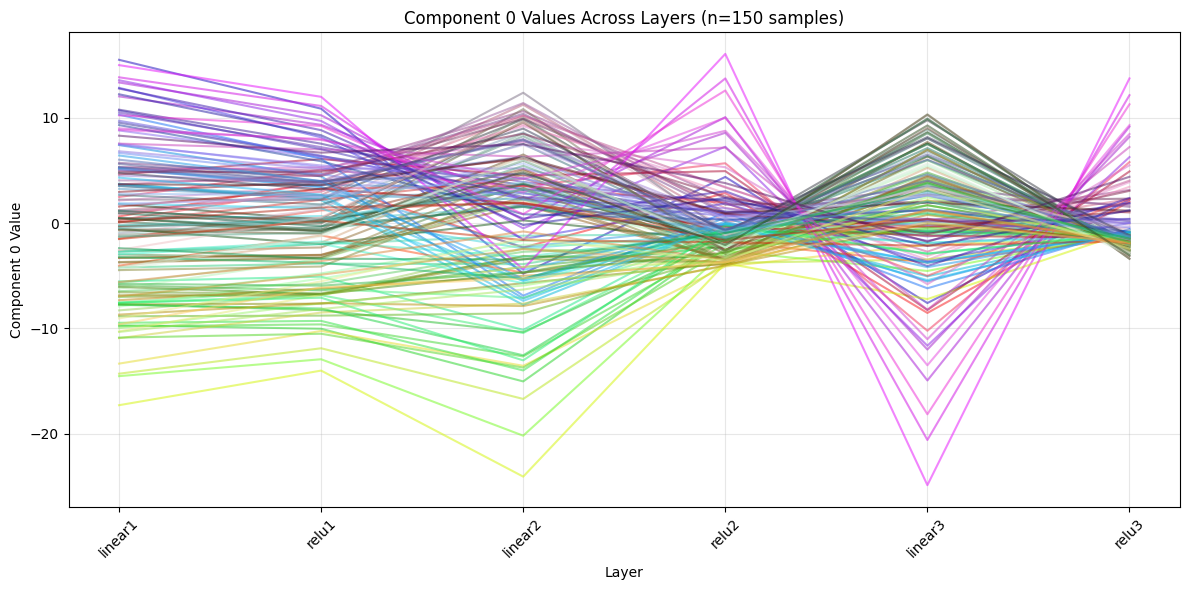

In [194]:
# Plot single component trajectories
plot_single_component_across_layers(reduced_activations, inputs, n_samples=150)

# Plot 2D trajectories
#plot_2d_layer_trajectories(reduced_activations, inputs, n_samples=150)

# Plot 3D trajectories

plot_3d_layer_components_interactive(reduced_activations, inputs, n_samples=150, y_comp=0, z_comp=1)

#plot_3d_layer_trajectories(reduced_activations, inputs, n_samples=50)

In [161]:
def find_nearest_samples(query_features, reference_features, query_idx=None, k=5, adaptive_k=False, verbose=True):
    """
    Find k-nearest neighbors for a query sample using euclidean distance, excluding the query itself
    
    Args:
        query_features: Query sample features (n_features,) or (1, n_features)
        reference_features: Reference dataset features (n_samples x n_features)
        query_idx: Index of query in reference set (to exclude from search)
        k: Number of neighbors to find (default=5)
        adaptive_k: If True, k = sqrt(n_samples) (default=False)
    
    Returns:
        tuple: (indices, distances)
            - indices: Indices of k nearest neighbors
            - distances: Corresponding distances
    """
    from sklearn.neighbors import NearestNeighbors
    
    # Ensure query is 2D
    if query_features.ndim == 1:
        query_features = query_features.reshape(1, -1)
    
    # Set k adaptively if requested
    if adaptive_k:
        k = int(np.sqrt(len(reference_features)))
        
        if verbose:
            print(f"Using adaptive k = {k}")
    
    # If query_idx provided, remove it from reference set
    if query_idx is not None:
        mask = np.ones(len(reference_features), dtype=bool)
        mask[query_idx] = False
        search_features = reference_features[mask]
    else:
        search_features = reference_features
    
    # Create and fit KNN model
    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(search_features)
    
    # Find k nearest neighbors
    distances, indices = knn.kneighbors(query_features)
    
    # Adjust indices if we removed query sample
    if query_idx is not None:
        indices = indices.flatten()
        # Adjust indices to account for removed query sample
        indices = np.array([idx if idx < query_idx else idx + 1 for idx in indices])
    else:
        indices = indices.flatten()
    
    distances = distances.flatten()
    
    if verbose:
        print(f"\nFound {k} nearest neighbors:")
        
    for idx, dist in zip(indices, distances):
        if verbose:
            print(f"Sample {idx}: distance = {dist:.4f}")
    
    return indices, distances



# With flattened activations:
query_idx = np.random.randint(0, len(flattened_activations))

indices, distances = find_nearest_samples(
    flattened_activations[query_idx],  # query features
    flattened_activations,             # reference features
    query_idx=query_idx,               # index to exclude
    k=10
)

# With original inputs:
indices, distances = find_nearest_samples(
    inputs[query_idx],
    inputs,
    query_idx=query_idx,
    k=10
)

# With original outputs:
indices, distances = find_nearest_samples(
    outputs[query_idx],
    outputs,
    query_idx=query_idx,
    k=10
)


Found 10 nearest neighbors:
Sample 346: distance = 2.9484
Sample 98: distance = 5.3533
Sample 242: distance = 5.4134
Sample 340: distance = 5.5475
Sample 248: distance = 6.1279
Sample 231: distance = 6.2587
Sample 406: distance = 6.5612
Sample 293: distance = 7.4262
Sample 194: distance = 7.8900
Sample 127: distance = 8.2862

Found 10 nearest neighbors:
Sample 346: distance = 0.0786
Sample 248: distance = 0.1067
Sample 340: distance = 0.1255
Sample 196: distance = 0.1385
Sample 120: distance = 0.1396
Sample 98: distance = 0.1424
Sample 242: distance = 0.1534
Sample 127: distance = 0.1546
Sample 327: distance = 0.1564
Sample 433: distance = 0.1584

Found 10 nearest neighbors:
Sample 346: distance = 0.0811
Sample 199: distance = 0.0877
Sample 98: distance = 0.0930
Sample 248: distance = 0.0961
Sample 340: distance = 0.0973
Sample 196: distance = 0.1236
Sample 231: distance = 0.1313
Sample 164: distance = 0.1394
Sample 242: distance = 0.1405
Sample 127: distance = 0.1435



Found 5 nearest neighbors:
Sample 32: distance = 4.4315
Sample 178: distance = 4.6993
Sample 458: distance = 4.7277
Sample 14: distance = 5.0474
Sample 377: distance = 6.6654

Weight distribution:
Sample 32: distance = 4.4315, weight = 0.2515
Sample 178: distance = 4.6993, weight = 0.2211
Sample 458: distance = 4.7277, weight = 0.2183
Sample 14: distance = 5.0474, weight = 0.1910
Sample 377: distance = 6.6654, weight = 0.1181

Blended RGB: [0.87905299 0.2320415  0.86762987]

Weight distribution:
Sample 32: distance = 4.4315, weight = 0.2515
Sample 178: distance = 4.6993, weight = 0.2211
Sample 458: distance = 4.7277, weight = 0.2183
Sample 14: distance = 5.0474, weight = 0.1910
Sample 377: distance = 6.6654, weight = 0.1181

Blended HSV: [0.81008769 0.74966673 0.94303384]


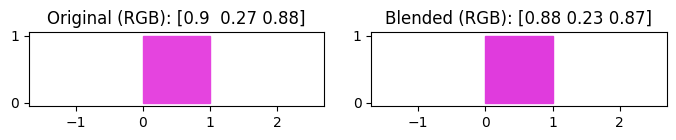

In [162]:
def blend_by_distance(indices, distances, features, softmax_temp=1.0, verbose=True):
    """
    Create weighted blend of features based on distance-derived weights
    
    Args:
        indices: Array of indices for nearest neighbors
        distances: Array of corresponding distances
        features: Feature array to blend from (inputs/outputs/activations)
        softmax_temp: Temperature for softmax weighting (default=1.0)
            - Lower values make weights more extreme
            - Higher values make weights more uniform
    
    Returns:
        tuple: (blended_result, weights)
            - blended_result: Weighted average of nearest neighbor features
            - weights: Weights used for blending
    """
    # Convert distances to weights using softmax
    # First invert distances so smaller distances get larger weights
    inv_distances = 1 / (distances + 1e-6)  # Add small epsilon to avoid division by 0
    
    # Apply temperature scaling
    scaled_distances = inv_distances / softmax_temp
    
    # Convert to softmax weights
    exp_distances = np.exp(scaled_distances)
    weights = exp_distances / np.sum(exp_distances)
    
    # Get features for the nearest neighbors
    neighbor_features = features[indices]
    
    # Calculate weighted average
    blended_result = np.sum(neighbor_features * weights[:, np.newaxis], axis=0)
    
    # Print weight distribution
    if verbose:
        print("\nWeight distribution:")
        
    for idx, (i, d, w) in enumerate(zip(indices, distances, weights)):
        
        if verbose:
            print(f"Sample {i}: distance = {d:.4f}, weight = {w:.4f}")
        
    return blended_result, weights


# Get nearest neighbors
query_idx = np.random.randint(0, len(inputs))
indices, distances = find_nearest_samples(
    flattened_activations[query_idx],
    flattened_activations,
    query_idx=query_idx,
    k=5
)

# Blend RGB inputs
blended_rgb, weights = blend_by_distance(indices, distances, inputs, softmax_temp=0.1)
print("\nBlended RGB:", blended_rgb)

# Or blend HSV outputs
blended_hsv, weights = blend_by_distance(indices, distances, outputs, softmax_temp=0.1)
print("\nBlended HSV:", blended_hsv)

# Visualize original vs blended
compare_values_side_by_side(
    inputs[query_idx],  # Original
    blended_rgb,        # Blended
    titles=('Original', 'Blended'),
    color_space='rgb'
)


In [163]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler


def process_new_color_sample(model, rgb_color, layer_sizes=[128, 128, 64], n_components=10):
    """
    Process a new RGB color through the model and get reduced layer activations
    
    Args:
        model: Trained neural network model
        rgb_color: RGB color array [r, g, b] with values in [0,1]
        layer_sizes: List of layer sizes (default=[128, 128, 64])
        n_components: Number of PCA components per layer (default=10)
        
    Returns:
        tuple: (new_input, new_flattened, all_activations, new_output)
            - new_input: Original RGB input
            - new_flattened: Flattened reduced activations for all layers
            - all_activations: Dictionary with full model activations
            - new_output: Model's HSV output for the input color
    """
    # Collect activations for the new color
    new_input, new_activations, new_output = collect_single_color_activations(model, rgb_color)
    
    # Split activations by layer
    new_layer_acts = split_activations_by_layer(new_activations, layer_sizes)
    
    # Get the original layer activations for the whole dataset
    layer_activations = split_activations_by_layer(activations, layer_sizes)
    
    # Dictionary to store reduced activations
    reduced_new = {}
    
    # Process each layer
    for layer_name in layer_activations.keys():
        # Get original layer data for fitting PCA
        orig_layer = layer_activations[layer_name]
        new_layer = new_layer_acts[layer_name]
        
        # Standardize using the original data
        scaler = StandardScaler()
        orig_scaled = scaler.fit_transform(orig_layer)
        
        # Transform new data using the same scaler
        new_scaled = scaler.transform(new_layer)
        
        # Fit PCA on original data and transform new data
        pca = PCA(n_components=n_components)
        pca.fit(orig_scaled)
        reduced_new[f"{layer_name}_reduced"] = pca.transform(new_scaled)
    
    # Flatten the reduced activations
    new_flattened, layer_names = flatten_layer_activations(reduced_new)
    
    return new_input, new_flattened, new_layer_acts, new_output

In [164]:
# Generate random RGB color
rgb_color = np.random.uniform(0, 1, 3)

# Process the new color
new_input, new_flattened, new_activations = process_new_color_sample(
    model, 
    rgb_color, 
    n_components=10
)

# Find nearest neighbors using the flattened activations
indices, distances = find_nearest_samples(
    new_flattened,           # Query features
    flattened_activations,   # Reference features
    k=15
)

# Blend results based on distances
blended_rgb, weights = blend_by_distance(indices, distances, inputs, softmax_temp=0.1)

# Blend results based on distances
blended_hsv, weights = blend_by_distance(indices, distances, outputs, softmax_temp=0.1)

# Visualize results
compare_values_side_by_side(
    new_input[0],    # Original random color
    blended_rgb,     # Blended result
    titles=('Random Input', 'Nearest Blend'),
    color_space='rgb'
)


Activation shapes by layer:
linear1: (1, 128)
relu1: (1, 128)
linear2: (1, 128)
relu2: (1, 128)
linear3: (1, 64)
relu3: (1, 64)
Activation shapes by layer:
linear1: (500, 128)
relu1: (500, 128)
linear2: (500, 128)
relu2: (500, 128)
linear3: (500, 64)
relu3: (500, 64)
Input shape per layer: (1, 10)
Number of layers: 6
Output shape: (1, 60)


ValueError: too many values to unpack (expected 3)

In [165]:
def compare_colors_with_distance(color1, color2, titles=('Color 1', 'Color 2')):
    """
    Display two colors side by side with their L2 distance
    
    Args:
        color1: First RGB color array [r, g, b]
        color2: Second RGB color array [r, g, b]
        titles: Tuple of titles for the two colors (default=('Color 1', 'Color 2'))
    """
    plt.figure(figsize=(4, 2))
    
    # Ensure colors are 1D arrays
    color1 = color1[0] if color1.ndim > 1 else color1
    color2 = color2[0] if color2.ndim > 1 else color2
    
    # Calculate L2 distance
    l2_dist = np.linalg.norm(color1 - color2)
    
    # Plot colors
    plt.subplot(1, 2, 1)
    plt.imshow([[color1]])
    plt.title(titles[0])
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow([[color2]])
    plt.title(f'{titles[1]}\nL2: {l2_dist:.4f}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [166]:
# Generate random RGB color
rgb_color = np.random.uniform(0, 1, 3)

# Process through model
new_input, new_flattened, new_activations, new_output = process_new_color_sample(
    model, 
    rgb_color, 
    n_components=10
)

# Convert HSV output to RGB for comparison
output_rgb = np.array(hsv_to_rgb(new_output[0][0], new_output[0][1], new_output[0][2]))


Activation shapes by layer:
linear1: (1, 128)
relu1: (1, 128)
linear2: (1, 128)
relu2: (1, 128)
linear3: (1, 64)
relu3: (1, 64)
Activation shapes by layer:
linear1: (500, 128)
relu1: (500, 128)
linear2: (500, 128)
relu2: (500, 128)
linear3: (500, 64)
relu3: (500, 64)
Input shape per layer: (1, 10)
Number of layers: 6
Output shape: (1, 60)


In [167]:
def color_distance(color1, color2):
    """
    Calculate L2 distance between two colors
    
    Args:
        color1: First color array [r,g,b] or [[r,g,b]]
        color2: Second color array [r,g,b] or [[r,g,b]]
    
    Returns:
        float: L2 distance between the colors
    """
    # Ensure 1D arrays
    c1 = color1[0] if color1.ndim > 1 else color1
    c2 = color2[0] if color2.ndim > 1 else color2
    
    return np.linalg.norm(c1 - c2)

Activation shapes by layer:
linear1: (1, 128)
relu1: (1, 128)
linear2: (1, 128)
relu2: (1, 128)
linear3: (1, 64)
relu3: (1, 64)
Activation shapes by layer:
linear1: (500, 128)
relu1: (500, 128)
linear2: (500, 128)
relu2: (500, 128)
linear3: (500, 64)
relu3: (500, 64)
Input shape per layer: (1, 10)
Number of layers: 6
Output shape: (1, 60)


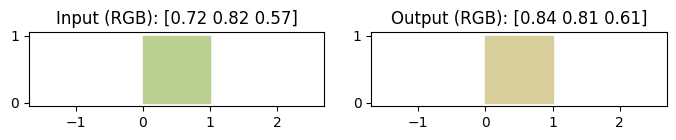

Distance:  0.122543715


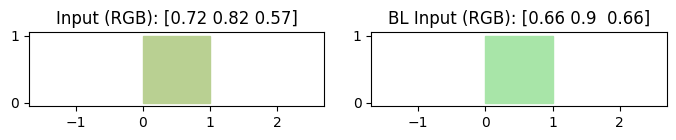

Distance:  0.1356538072241637


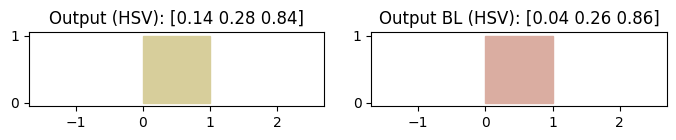

Distance:  0.11056124171714318


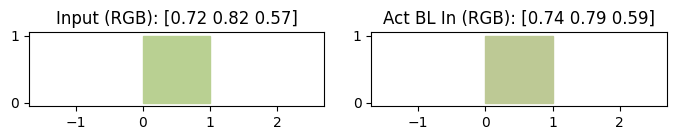

Distance:  0.03563496223358362


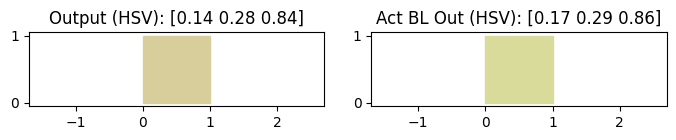

Distance:  0.037564403598339714


In [186]:
# Generate random RGB color
rgb_color = np.random.uniform(0, 1, 3)

# Process through model
new_input, new_flattened, new_activations, new_output = process_new_color_sample(
    model, 
    rgb_color, 
    n_components=10
)

# Convert HSV output to RGB for comparison
output_rgb = np.array(hsv_to_rgb(new_output[0][0], new_output[0][1], new_output[0][2]))


compare_values_side_by_side(new_input[0], output_rgb, titles=('Input', 'Output'), color_space='rgb')
print("Distance: ",color_distance(new_input, output_rgb))

# Find nearest neighbors using the flattened activations
indices, distances = find_nearest_samples(
    new_input,           # Query features
    inputs,   # Reference features
    k=15,
    verbose=False
)

blended_rgb, weights = blend_by_distance(indices, distances, inputs, softmax_temp=0.1, verbose=False)

compare_values_side_by_side(new_input[0], blended_rgb, titles=('Input', 'BL Input'), color_space='rgb')
print("Distance: ",color_distance(new_input[0], blended_rgb))

# Find nearest neighbors using the flattened activations
indices, distances = find_nearest_samples(
    new_output,           # Query features
    outputs,   # Reference features
    k=15,
    verbose=False
)

blended_hsv, weights = blend_by_distance(indices, distances, outputs, softmax_temp=0.1, verbose=False)

compare_values_side_by_side(new_output[0], blended_hsv, titles=('Output', 'Output BL'), color_space='hsv')
print("Distance: ",color_distance(new_output[0], blended_hsv))



# Find nearest neighbors using the flattened activations
indices, distances = find_nearest_samples(
    new_flattened,           # Query features
    flattened_activations,   # Reference features
    k=15,
    verbose=False
)

# Blended Input based on flattened activations
blended_rgb, weights = blend_by_distance(indices, distances, inputs, softmax_temp=0.1, verbose=False)

compare_values_side_by_side(new_input[0], blended_rgb, titles=('Input', 'Act BL In'), color_space='rgb')
print("Distance: ",color_distance(new_input[0], blended_rgb))


# Blended Output based on flattened activations
blended_hsv, weights = blend_by_distance(indices, distances, outputs, softmax_temp=0.1, verbose=False)

compare_values_side_by_side(new_output[0], blended_hsv, titles=('Output', 'Act BL Out'), color_space='hsv')
print("Distance: ",color_distance(new_output[0], blended_hsv))